<a href="https://colab.research.google.com/github/prateekjoshi565/Fine-Tuning-BERT/blob/master/Fine_Tuning_BERT_for_Spam_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Transformers Library

In [56]:
!wget https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/train_stances.csv
!wget https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/train_bodies.csv
!wget https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/competition_test_bodies.csv
!wget https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/competition_test_stances.csv

--2022-08-05 19:10:34--  https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/train_stances.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4255300 (4.1M) [text/plain]
Saving to: ‘train_stances.csv’

train_stances.csv   100%[===================>]   4.06M  --.-KB/s    in 0.04s   

2022-08-05 19:10:36 (94.0 MB/s) - ‘train_stances.csv’ saved [4255300/4255300]

--2022-08-05 19:10:37--  https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/train_bodies.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37523

In [30]:
!pip install transformers==3.1.0

In [31]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU


# Load Dataset

In [32]:
data_bodies = pd.read_csv("train_bodies.csv")
data_stances = pd.read_csv("train_stances.csv")



In [33]:

data = data_stances.join(data_bodies.set_index("Body ID"), on="Body ID")
# test_data = test_stances.join(test_bodies.set_index("Body ID"), on="Body ID")


In [34]:
cols = ['Headline', 'articleBody']
stance_dict = {"agree":0,"disagree":1,"discuss":2  ,"unrelated" :3}
# data['text'] = data[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
data['label'] = data['Stance'].apply(lambda val:stance_dict[val] )

In [6]:
selected_features = ['label','articleBody','Headline']
df = data.loc[:, data.columns.isin(selected_features)]

In [62]:
df.shape


(49972, 3)

In [63]:
df.head()


,Headline,articleBody,label
0,Police find mass graves with at least '15 bodi...,Danny Boyle is directing the untitled film\n\n...,3
1,Hundreds of Palestinians flee floods in Gaza a...,Hundreds of Palestinians were evacuated from t...,0
2,"Christian Bale passes on role of Steve Jobs, a...",30-year-old Moscow resident was hospitalized w...,3
3,HBO and Apple in Talks for $15/Month Apple TV ...,(Reuters) - A Canadian soldier was shot at the...,3
4,Spider burrowed through tourist's stomach and ...,"Fear not arachnophobes, the story of Bunbury's...",1


In [64]:
# check class distribution
df['label'].value_counts(normalize = True)

3    0.731310
2    0.178280
0    0.073601
1    0.016809
Name: label, dtype: float64

# Split train dataset into train, validation and test sets

In [ ]:
# train_text, temp_text, train_labels, temp_labels = train_test_split(df['Headline'],df['articleBody'], df['label'], 
#                                                                     random_state=2018, 
#                                                                     test_size=0.3, 
#                                                                     stratify=df['label'])


# # we will use temp_text and temp_labels to create validation and test set
# val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
#                                                                 random_state=2018, 
#                                                                 test_size=0.5, 
#                                                                 stratify=temp_labels)

In [7]:
train_headline, temp_headline, train_body, temp_body, train_labels, temp_labels = train_test_split(df['Headline'], df['articleBody'],
                                                                    df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_headline, test_headline, val_body, test_body, val_labels, test_labels = train_test_split(temp_headline, temp_body, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

48233    Rajasthan, Oct 14: A man learnt a lesson, the ...
48068    This rumour is ridiculous, but it's pretty amu...
20368    Airline travelers worried about Ebola are taki...
32558    A pro-Isis news agency has released a video pu...
30638    A hallucinogenic fungi has been found growing ...
                               ...                        
10939    When a report went viral that NBC meteorologis...
19481    The man who jumped the White House fence this ...
26342    A Sept. 8 U.S. Department of Defense news arti...
33870    We're just two months away from the Apple Watc...
35630    Critics slammed Vogue’s recent Kimye cover as ...
Name: articleBody, Length: 34980, dtype: object


# Import BERT Model and BERT Tokenizer

In [8]:
# import BERT-base pretrained model
bert_head = AutoModel.from_pretrained('bert-base-uncased')
bert_body = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
# # sample data
# text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# # encode text
# sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
# output
# print(sent_id)

# Tokenization

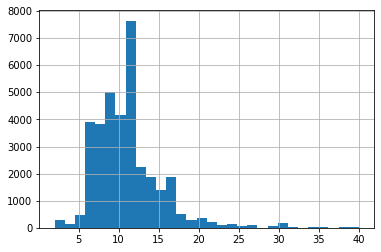

In [16]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_headline]
# seq_len_b = [len(i.split()) for i in train_body]

pd.Series(seq_len).hist(bins = 30)

In [9]:
max_seq_len_h = 20
max_seq_len_b = 512

In [10]:
# tokenize and encode sequences in the training set
tokens_train_head = tokenizer.batch_encode_plus(
    train_headline.tolist(),
    max_length = max_seq_len_h,
    padding='max_length',
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the training set
tokens_train_body = tokenizer.batch_encode_plus(
    train_body.tolist(),
    max_length = max_seq_len_b,
    padding='max_length',
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# # tokenize and encode sequences in the validation set
# tokens_val = tokenizer.batch_encode_plus(
#     val_text.tolist(),
#     max_length = max_seq_len,
#     padding='max_length',  
#     pad_to_max_length=True,
#     truncation=True,
#     return_token_type_ids=False
# )

# tokenize and encode sequences in the validation set
tokens_val_head = tokenizer.batch_encode_plus(
    val_headline.tolist(),
    max_length = max_seq_len_h,
    padding='max_length',
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val_body = tokenizer.batch_encode_plus(
    val_body.tolist(),
    max_length = max_seq_len_b,
    padding='max_length',
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)


In [ ]:
# # tokenize and encode sequences in the test set
# tokens_test = tokenizer.batch_encode_plus(
#     test_text.tolist(),
#     max_length = max_seq_len,
#     padding='max_length',
#     pad_to_max_length=True,
#     truncation=True,
#     return_token_type_ids=False
# )

In [43]:
# tokenize and encode sequences in the test set
tokens_test_head = tokenizer.batch_encode_plus(
    test_headline.tolist(),
    max_length = max_seq_len_h,
    padding='max_length',
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test_body = tokenizer.batch_encode_plus(
    test_body.tolist(),
    max_length = max_seq_len_b,
    padding='max_length',
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)


# Convert Integer Sequences to Tensors

In [12]:
# for train set

train_seq_head = torch.tensor(tokens_train_head['input_ids'])
train_mask_head = torch.tensor(tokens_train_head['attention_mask'])

train_y = torch.tensor(train_labels.tolist())



train_seq_body = torch.tensor(tokens_train_body['input_ids'])
train_mask_body = torch.tensor(tokens_train_body['attention_mask'])



# # for validation set
# val_seq = torch.tensor(tokens_val['input_ids'])
# val_mask = torch.tensor(tokens_val['attention_mask'])
# val_y = torch.tensor(val_labels.tolist())

# for val set

val_seq_head = torch.tensor(tokens_val_head['input_ids'])
val_mask_head = torch.tensor(tokens_val_head['attention_mask'])

val_y = torch.tensor(val_labels.tolist())



val_seq_body = torch.tensor(tokens_val_body['input_ids'])
val_mask_body = torch.tensor(tokens_val_body['attention_mask'])



In [ ]:
# # for test set
# test_seq = torch.tensor(tokens_test['input_ids'])
# test_mask = torch.tensor(tokens_test['attention_mask'])
# test_y = torch.tensor(test_labels.tolist())

In [44]:
test_seq_head = torch.tensor(tokens_test_head['input_ids'])
test_mask_head = torch.tensor(tokens_test_head['attention_mask'])

test_y = torch.tensor(test_labels.tolist())



test_seq_body = torch.tensor(tokens_test_body['input_ids'])
test_mask_body = torch.tensor(tokens_test_body['attention_mask'])


# Create DataLoaders

In [13]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 64

# wrap tensors
train_data = TensorDataset(train_seq_head,train_seq_body,train_mask_head, train_mask_body, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq_head,val_seq_body,val_mask_head, val_mask_body, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [45]:
# wrap tensors
test_data = TensorDataset(test_seq_head,test_seq_body,test_mask_head, test_mask_body, test_y)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

# dataLoader for validation set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

In [ ]:
# from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# #define a batch size
# batch_size = 32

# # wrap tensors
# test_data = TensorDataset(test_seq, test_mask, test_y)

# # sampler for sampling the data during training
# test_sampler = RandomSampler(test_data)

# # dataLoader for train set
# test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


# Freeze BERT Parameters

In [14]:
# freeze all the parameters
for param in bert_head.parameters():
    param.requires_grad = False

# freeze all the parameters
for param in bert_body.parameters():
    param.requires_grad = False

# Define Model Architecture

In [15]:
class BERT_Arch(nn.Module):

    def __init__(self, bert_head,bert_body):
      
      super(BERT_Arch, self).__init__()

      self.bert_head = bert_head
      self.bert_body = bert_body

      # Max pooling layer
      self.max_pooling = nn.MaxPool1d(4,stride=4)
      
      # dropout layer

      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc = nn.Linear(384,768)

      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,4)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id_head,sent_id_body, mask_head,mask_body):
      # print(sent_id.size())
      # print(mask.size())
      #pass the inputs to the model  
      _, cls_hs_h = self.bert_head(sent_id_head, attention_mask=mask_head)
      _, cls_hs_b = self.bert_body(sent_id_body, attention_mask=mask_body)
      cls_hs = torch.cat((cls_hs_h,cls_hs_b),dim=1)
      max_pool_out =torch.squeeze(self.max_pooling(cls_hs.unsqueeze(0)))
      
      fc_out = self.fc(max_pool_out)
      fc_act_out = self.relu(fc_out)

      x = self.fc1(fc_act_out)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [16]:
# pass the pre-trained BERT to our define architecture
device = torch.device("cuda")
model = BERT_Arch(bert_head,bert_body)

# push the model to GPU
model = model.to(device)

In [17]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

# Find Class Weights

In [18]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights

class_wts = compute_class_weight('balanced', classes = np.unique(train_labels), y =train_labels)

print(class_wts)

[ 3.3961165  14.87244898  1.40234124  0.34185528]


In [35]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 50

# Fine-Tune BERT

In [20]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id_head,sent_id_body, mask_head,mask_body, labels = batch
    # print(sent_id)

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id_head,sent_id_body, mask_head,mask_body)
    #print("Predicted val: {}".format(preds))
   
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [21]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id_head,sent_id_body, mask_head,mask_body, labels = batch
    # deactivate autograd
    with torch.no_grad():
      

      # model predictions
      preds = model(sent_id_head,sent_id_body, mask_head,mask_body)
      
      # compute the validation loss between actual and predicted values
      
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [36]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights_bert_2.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 50
  Batch    50  of    547.
  Batch   100  of    547.
  Batch   150  of    547.
  Batch   200  of    547.
  Batch   250  of    547.
  Batch   300  of    547.
  Batch   350  of    547.
  Batch   400  of    547.
  Batch   450  of    547.
  Batch   500  of    547.

Evaluating...
  Batch    50  of    118.
  Batch   100  of    118.

Training Loss: 1.316
Validation Loss: 1.356

 Epoch 2 / 50
  Batch    50  of    547.
  Batch   100  of    547.
  Batch   150  of    547.
  Batch   200  of    547.
  Batch   250  of    547.
  Batch   300  of    547.
  Batch   350  of    547.
  Batch   400  of    547.
  Batch   450  of    547.
  Batch   500  of    547.

Evaluating...
  Batch    50  of    118.
  Batch   100  of    118.

Training Loss: 1.324
Validation Loss: 1.283

 Epoch 3 / 50
  Batch    50  of    547.
  Batch   100  of    547.
  Batch   150  of    547.
  Batch   200  of    547.
  Batch   250  of    547.
  Batch   300  of    547.
  Batch   350  of    547.
  Batch   400  of    547.
  B

# Load Saved Model

In [46]:
#load weights of best model
path = 'saved_weights_bert_2.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [47]:
# function for evaluating the model
def evaluate_test():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(test_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id_head,sent_id_body, mask_head,mask_body, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id_head,sent_id_body, mask_head,mask_body)

      # compute the validation loss between actual and predicted values
      
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(test_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [48]:
_,total_preds = evaluate_test()


Evaluating...
  Batch    50  of    118.
  Batch   100  of    118.


In [ ]:
print(total_pred.shape)

(3812, 4)


In [50]:
# model's performance
preds = np.argmax(total_preds, axis = 1)
test_y_array = test_y.detach().cpu().numpy()
print(classification_report(test_y_array, preds))
# confusion matrix
pd.crosstab(test_y_array, preds)

              precision    recall  f1-score   support

           0       0.15      0.47      0.23       552
           1       0.09      0.55      0.15       126
           2       0.32      0.56      0.41      1336
           3       0.83      0.41      0.55      5482

    accuracy                           0.44      7496
   macro avg       0.35      0.50      0.33      7496
weighted avg       0.68      0.44      0.49      7496



col_0,0,1,2,3
row_0,,,,
0,262,71,103,116
1,22,69,13,22
2,157,130,744,305
3,1310,502,1434,2236


In [ ]:
# get predictions for test data

with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

In [ ]:
# confusion matrix
pd.crosstab(test_y, preds)